[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shashist/recsys-course/blob/master/week_03_matrix_factorization/rs_seminar_svd.ipynb)

In [1]:
from typing import Optional

import abc
import os
import numpy as np
import math
import pandas as pd

from copy import deepcopy

from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path = 'drive/MyDrive/recsys_teaching/mts_lib_copy/'
log_name = 'interactions.csv'
u_features_name = 'users.csv'
i_features_name = 'items.csv'

In [4]:
SEED = 123
K=10

# RS datasets and SVD
- dataset EDA
- scipy sparse SVD
- personalized recommendations
- item2item recommendations

# Dataset

[MTS Library](https://www.kaggle.com/sharthz23/mts-library): book reading history for russian reading service.

### Preprocessing

In [5]:
df = pd.read_csv(os.path.join(data_path, log_name), sep=',')

In [6]:
assert df.shape[0] == 1533078

In [7]:
df.head(2)

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01
1,127290,140952,58,NaN,2018-01-01


In [8]:
%%time
# конвертируем в дату
df.loc[:, 'start_date'] = pd.to_datetime(df['start_date'], format="%Y-%m-%d")
# удаляем дубликаты, оставляя последний по времени
df = df.sort_values('start_date').drop_duplicates(subset=['user_id', 'item_id'], keep='last')

u_features = pd.read_csv(data_path+u_features_name, sep=',')
i_features = pd.read_csv(data_path+i_features_name, sep=',')
i_features.rename(columns={'id': 'item_id'}, inplace=True)

CPU times: user 11.9 s, sys: 405 ms, total: 12.3 s
Wall time: 20.3 s


### Data

In [9]:
u_features.head(2)

,user_id,age,sex
0,1,45_54,NaN
1,2,18_24,0.0


In [10]:
%%time
i_features.head(2)

CPU times: user 124 µs, sys: 8 µs, total: 132 µs
Wall time: 136 µs


,item_id,title,genres,authors,year
0,128115,Ворон-челобитчик,"Зарубежные детские книги,Сказки,Зарубежная кла...",Михаил Салтыков-Щедрин,1886
1,210979,Скрипка Ротшильда,"Классическая проза,Литература 19 века,Русская ...",Антон Чехов,1894


In [11]:
i_features.shape, i_features['item_id'].isin(df['item_id'].unique()).shape

((59599, 5), (59599,))

In [12]:
def get_log_info(log, user_id='user_id', item_id='item_id'):
    print(f'Num interactions = {log.shape[0]},\nnum users = {log[user_id].nunique()},\nnum items = {log[item_id].nunique()}')

In [13]:
get_log_info(df)

Num interactions = 1532998,
num users = 151600,
num items = 59599


In [14]:
f"Num ratings = {(~df['rating'].isna()).sum()}, is much less than reading progress data ({(~df['progress'].isna()).sum()})"


'Num ratings = 285337, is much less than reading progress data (1532998)'

In [15]:
df.head(2)

,user_id,item_id,progress,rating,start_date
0,126706,14433,80,NaN,2018-01-01 00:00:00
1437,97128,245669,1,NaN,2018-01-01 00:00:00


## RS data features
- user/session and item ids are available
- interactions timestamp are often present
- user feedback is known (fact of features)

In [16]:
df['progress'].min(), df['progress'].max(), df['rating'].min(), df['rating'].max()

(0, 100, 1.0, 5.0)

## Feedback types

Progress and rating

**Explicit**
- less data available
- explicit opinions
- biased

**Implicit**
- lots of data
- heterogeneous
- difficult to distinguish positive and negative feedback
- fair preferences

## RS tasks

* top-k personalized recommendations
* reranking
* find similar item2user, item2item
* session-based, next basket, etc.

# EDA

#### Reading progress dist

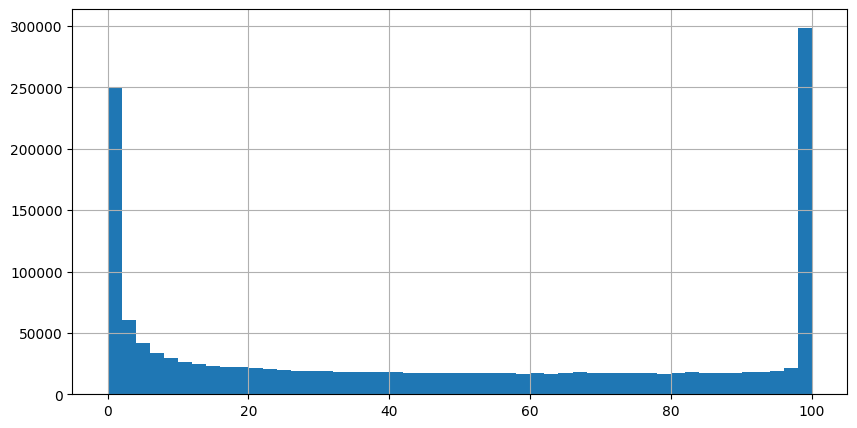

In [17]:
df['progress'].hist(bins=50, figsize=(10, 5));

#### Rating dist

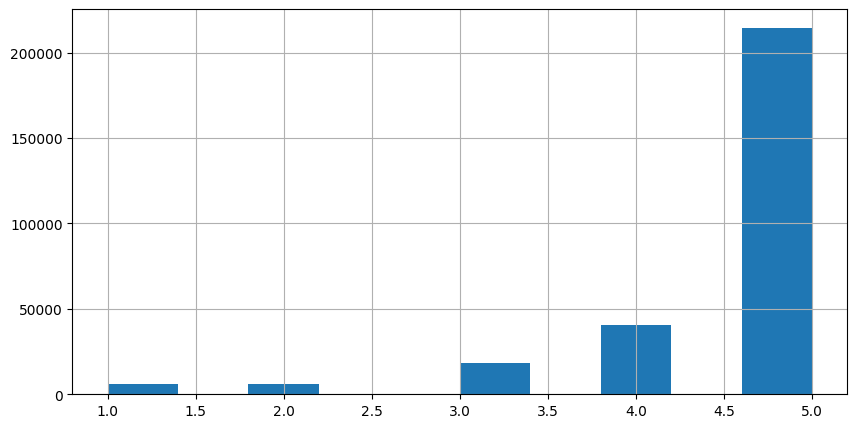

In [18]:
df['rating'].hist(bins=10, figsize=(10, 5));

In [19]:
df['rating'].value_counts()

,count
rating,
5.0,214703
4.0,40382
3.0,18273
1.0,6115
2.0,5864


#### Num interactions per user/item

In [20]:
def group_by_and_plot(df, group_by_name, rating_col_name, quantile=0.99, title=''):
    grouped = df.groupby(group_by_name)[rating_col_name].count()
    print(grouped.describe(percentiles=[0.05, .25, .5, .75, 0.95]))
    grouped[grouped < grouped.quantile(quantile)].plot(kind='hist', bins=50, figsize=(10, 5), title=title)
    return grouped

count    151600.000000
mean         10.112124
std          20.922963
min           1.000000
5%            3.000000
25%           5.000000
50%           7.000000
75%          10.000000
95%          20.000000
max        2091.000000
Name: progress, dtype: float64


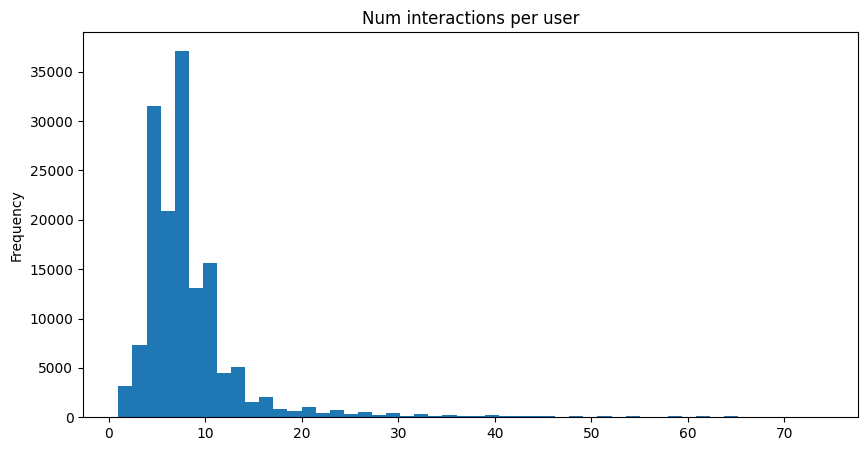

In [21]:
user_count = group_by_and_plot(df, group_by_name='user_id', rating_col_name='progress', quantile=0.99, title='Num interactions per user')

count    101885.000000
mean          2.800579
std          10.026988
min           1.000000
5%            1.000000
25%           1.000000
50%           1.000000
75%           2.000000
95%           5.000000
max         691.000000
Name: rating, dtype: float64


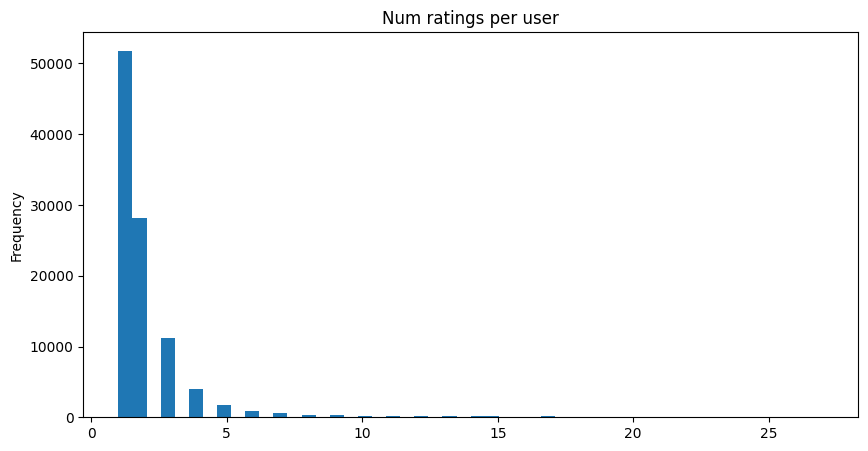

In [22]:
group_by_and_plot(df[~df['rating'].isna()], group_by_name='user_id', rating_col_name='rating', quantile=0.99, title='Num ratings per user');

count    59599.000000
mean        25.721875
std         60.665733
min          2.000000
5%           9.000000
25%         13.000000
50%         16.000000
75%         21.000000
95%         65.000000
max       6575.000000
Name: progress, dtype: float64


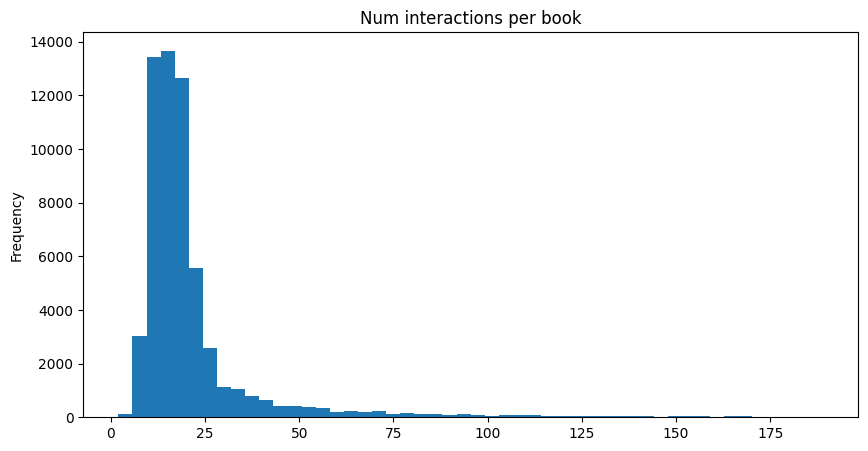

In [23]:
item_count = group_by_and_plot(df, group_by_name='item_id', rating_col_name='progress', quantile=0.99, title='Num interactions per book')

<a id='filter'></a>
# 0 Data filtering

What is a progress threshold for a relevant book?


### Leaving progress > 50

In [24]:
filtered_df = df[df['progress'] > 50]

In [25]:
get_log_info(filtered_df)

Num interactions = 712368,
num users = 143465,
num items = 59560


### Applying 5-filter strategy

1) books with num interactions >= 5

2) users with num interactions >= 5

In [26]:
item_counts = filtered_df.groupby('item_id')['user_id'].count()
pop_items = item_counts[item_counts > 4]
filtered_df = filtered_df[filtered_df['item_id'].isin(pop_items.index)]

In [27]:
user_counts = filtered_df.groupby('user_id')['item_id'].count()
pop_users = user_counts[user_counts > 4]
filtered_df = filtered_df[filtered_df['user_id'].isin(pop_users.index)].copy()

In [28]:
get_log_info(filtered_df)

Num interactions = 423599,
num users = 33875,
num items = 50982


In [29]:
# assert filtered_df.shape[0] == 223005
# assert filtered_df['user_id'].nunique() == 5797

### Id conversion / label encoding



In [30]:
%%time
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
user_encoder.fit(filtered_df['user_id'])
item_encoder.fit(filtered_df['item_id'])

CPU times: user 97.8 ms, sys: 0 ns, total: 97.8 ms
Wall time: 95.4 ms


LabelEncoder()

In [31]:
i_features_filtered = i_features[i_features['item_id'].isin(filtered_df['item_id'].unique())].copy()
u_features_filtered = u_features[u_features['user_id'].isin(filtered_df['user_id'].unique())].copy()

In [32]:
%%time
filtered_df.loc[:, 'user_id'] = user_encoder.transform(filtered_df['user_id'])
filtered_df.loc[:, 'item_id'] = item_encoder.transform(filtered_df['item_id'])

CPU times: user 229 ms, sys: 1.51 ms, total: 230 ms
Wall time: 242 ms


In [33]:
%%time
i_features_filtered.loc[:, 'item_id'] = item_encoder.transform(i_features_filtered['item_id'])
u_features_filtered.loc[:, 'user_id'] = user_encoder.transform(u_features_filtered['user_id'])
# i_features_filtered.set_index('item_id', inplace=True)

CPU times: user 19.4 ms, sys: 40 µs, total: 19.4 ms
Wall time: 21.2 ms


In [34]:
i_features_filtered.sample(20)

,item_id,title,genres,authors,year
37862,50200,Политэкономия. Краткий курс,"Общая экономическая теория,Экономический анали...",NaN,2016
391,20131,Кабала святош,"Пьесы и драматургия,Литература 20 века,Русская...",Михаил Булгаков,1930
13629,48226,– Автора!,Современные детективы,Наталья Андреева,2006
32639,6063,Сеть,Современные детективы,Павел Астахов,2017
52260,8350,Муза ночных кошмаров,"Героическое фэнтези,Зарубежное фэнтези,Любовно...",Лэйни Тейлор,2018
19812,32784,Язык жестов в любви,"Семейная психология,Зарубежная психология,Соци...","Аллан Пиз,Барбара Пиз",2012
25566,4588,Как вести себя в библиотеке. Вредные советы,"Книги для детей,Детская проза,Современная русс...",Гульнара Лунгу,NaN
15151,34659,Неизвестный 1941. Остановленный блицкриг,"Общая история,Военное дело / спецслужбы",Алексей Исаев,2012
25931,19781,Ошибка капитана Шарки,"Зарубежные приключения,Литература 20 века,Морс...",Артур Конан Дойл,1910
57038,29527,Я научу тебя летать,Сказки,Александр Пронин,2009


In [35]:
TEST_BOOK = 36618
i_features_filtered[i_features_filtered['item_id'] == TEST_BOOK]

,item_id,title,genres,authors,year
43954,36618,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017


In [36]:
TEST_USER = 4
u_features_filtered[u_features_filtered['user_id'] == TEST_USER]

,user_id,age,sex
19,4,18_24,0.0


# 1 Data split

What could be the problem in spliiting without timestamp considering?
Will use global time split + users and interactions filtering.

To consider: cross-validation



### Global time split: last 10% of data to test

In [54]:
train = filtered_df[filtered_df['start_date'] <= filtered_df['start_date'].quantile(0.9)]
test = filtered_df[filtered_df['start_date'] > filtered_df['start_date'].quantile(0.9)]

In [55]:
assert train.shape[0] == 381710
assert test.shape[0] == 41889

### remove cold users

In [58]:
# counts_in_test = test.groupby('user_id')['item_id'].count()
# test = test[test['user_id'].isin(counts_in_test[counts_in_test > 4].index)].copy()
# test['rank'] = test.groupby('user_id')['start_date'].rank(method="first", ascending=True)
# test = test[test['rank'] <= 5].drop(columns=['rank'])

# remove cold users
test = test[test['user_id'].isin(train['user_id'].unique())]
# take a 1000 of users
test = test[test['user_id'] < 5000]
test_users = test['user_id'].drop_duplicates()

In [61]:
assert test.shape[0] == 6009

In [59]:
get_log_info(train)

Num interactions = 381710,
num users = 33810,
num items = 50435


In [60]:
get_log_info(test)

Num interactions = 6009,
num users = 1835,
num items = 4470


More examples of splitting are available [here](https://github.com/sb-ai-lab/RePlay/blob/main/examples/04_splitters.ipynb)

## 2. Metrics

In [62]:
K = 10

#### HitRate

$$HitRate@K(i) = \max_{j \in [1..K]}\mathbb{1}_{r_{ij}}$$


$$ HitRate@K = \frac{\sum_{i=1}^{N}HitRate@K(i)}{N} $$

$\mathbb{1}_{r_{ij}}$ -- indicator function stating that user $i$ interacted with item $j$

In [63]:
def user_hr(row):
    """
    Calculate HitRate value.

    'row' contains
        a list of ground truth items in ``gt_items`` and
        a list of recommended items in ``pred_list``.
    """
    for item in row['pred_list']:
        if item in row['gt_list']:
            return 1
    return 0

#### Coverage

$$Coverage@K=\frac{\left|\bigcup\limits_{u\in U} y_u\right|}{|I|}$$


In [64]:
def coverage(pred, k, all_items):
    pred_to_consider = set(leave_top_k(pred, k)['item_id'].values)
    all_items = set(all_items.values)
    return len(pred_to_consider & all_items) / len(all_items)

#### Wrapping

In [65]:
def metric_wrap(pred, ground_truth, k, metric_by_user):
    """
    Prepare data for metric calculation (create dataframe with columns 'user_id', 'pred_list', 'gt_list').

    'pred_list' is a list of top-k recommendation ordered by relevance (most relevant is the first)
    'gt_list' is a list of items from tests data.
    Return mean metric value and dataframe with metric value for each user
    """
    pred_cropped = leave_top_k(pred, k)
    # prepare score lists
    pred_grouped = (pred_cropped
                .sort_values(['user_id', 'rating'], ascending=[False, False])
                .groupby('user_id')['item_id']
                .apply(list).rename('pred_list')
               )
    gt_grouped = ground_truth.groupby('user_id')['item_id'].apply(list).rename('gt_list')
    to_compare = gt_grouped.to_frame().join(pred_grouped, how='left')
    to_compare['pred_list'] = to_compare['pred_list'].apply(lambda x: x if isinstance(x, list) else [])
    # compute metric
    metric_by_user = to_compare.apply(metric_by_user, axis=1)
    return metric_by_user.mean(), metric_by_user

In [66]:
def leave_top_k(pred: pd.DataFrame,
                 k: int=K,
                 group_by_col: str='user_id',
                 order_by_col: str='rating') -> pd.DataFrame:
    """
    crop predictions to leave top-k recommendations for each user
    """
    if pred.groupby(group_by_col)[group_by_col].count().max() <= k:
        return pred
    cropped_pred = deepcopy(pred)
    cropped_pred['rank'] = (cropped_pred
                            .groupby(group_by_col)[[order_by_col]]
                            .rank(method="first", ascending=False))
    cropped_pred = cropped_pred[cropped_pred['rank'] <= k].drop(columns=['rank'])
    return cropped_pred

In [67]:
def measure(pred, true, name, metrics_hist=None, cov_items=None):
    if metrics_hist is None:
        metrics_hist = pd.DataFrame(columns=['hit_rate@K', 'coverage@K'])
    metrics_hist.loc[name, 'hit_rate@K'] = metric_wrap(pred=pred, ground_truth=true, k=K, metric_by_user=user_hr)[0]

    if cov_items is not None:
        metrics_hist.loc[name, 'coverage@K'] = coverage(pred=pred, k=K, all_items=cov_items)
    return metrics_hist

## 3. Baseline (most popular)

In [68]:
popular_items = train['item_id'].value_counts().head(10).index

In [69]:
users = []
items = []
ratings = []

for i, user in enumerate(test_users):
    users.extend([user] * 10)
    items.extend(popular_items)
    ratings.extend([1] * 10)

In [70]:
popular_preds = pd.DataFrame({'user_id': users, 'item_id': items, 'rating': ratings})

In [71]:
%%time
metrics = measure(popular_preds, test, 'PopRec', cov_items=train['item_id'].drop_duplicates())
metrics.sort_values('hit_rate@K', ascending=False)

CPU times: user 154 ms, sys: 4.01 ms, total: 158 ms
Wall time: 159 ms


,hit_rate@K,coverage@K
PopRec,0.009809,0.000198


In [72]:
popularity = train.groupby('item_id')['user_id'].count().rename('popularity').sort_values(ascending=False)
items_with_pop = i_features_filtered.merge(popularity, right_index=True, left_on="item_id")
items_with_pop.sort_values('popularity', ascending=False)[:20]

,item_id,title,genres,authors,year,popularity
15077,14267,Зулейха открывает глаза,Современная русская литература,Гузель Яхина,2015,587
13860,50597,Черновик,Научная фантастика,Сергей Лукьяненко,2004-05,494
21079,19385,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё,2007,487
21704,42084,После,"Зарубежные любовные романы,Современные любовны...",Анна Тодд,2014,459
34174,39972,Земное притяжение,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017,393
12935,43572,Чистовик,Научная фантастика,Сергей Лукьяненко,2007,384
14065,17922,После ссоры,"Зарубежные любовные романы,Современные любовны...",Анна Тодд,2014,381
15548,25325,Пятьдесят оттенков серого,"Эротические романы,Зарубежные любовные романы",Э. Л. Джеймс,2012,335
7244,15722,"Сила подсознания, или Как изменить жизнь за 4 ...","Практическая эзотерика,Эзотерика / оккультизм,...",Джо Диспенза,2013,326
42956,43119,Струны волшебства. Книга первая. Страшные сказ...,"Героическое фэнтези,Книги про волшебников",Милена Завойчинская,2018,320


## 4. SVD

# Truncated SVD

Let's use [svds](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) from scipy.sparse.linalg. Absent ratings are imputed with zeros. Consider if the other approaches from today lecture better suit this dataset.

In [73]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [74]:
%%time
csr_train = csr_matrix((np.ones(train.shape[0]).astype(float), (train['user_id'], train['item_id'])))
user_vectors, singular_values, item_vectors = svds(A=csr_train, k=64)

CPU times: user 8.39 s, sys: 248 ms, total: 8.64 s
Wall time: 4.63 s


In [75]:
user_vectors.shape, singular_values.shape, item_vectors.shape

((33875, 64), (64,), (64, 50982))

In [76]:
np.allclose(item_vectors @ item_vectors.T, np.eye(item_vectors.shape[0], item_vectors.shape[0]))

True

In [77]:
import matplotlib.pyplot as plt

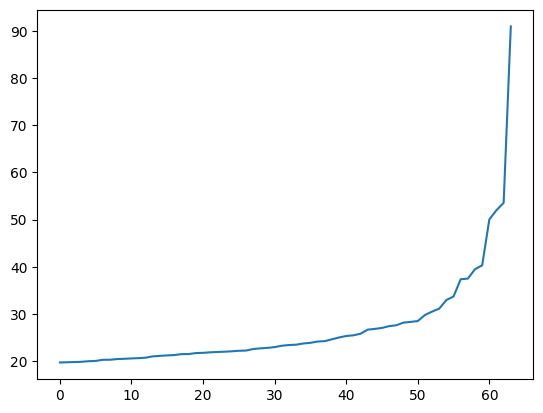

In [78]:
plt.plot(singular_values)

## Get top-10 personalized recommendations for user 4

In [79]:
u_features_filtered[u_features_filtered['user_id'] == TEST_USER]

,user_id,age,sex
19,4,18_24,0.0


In [80]:
train[train['user_id']== TEST_USER].merge(i_features_filtered, on='item_id').sort_values(by='start_date', ascending=False)

,user_id,item_id,progress,rating,start_date,title,genres,authors,year
27,4,27322,99,NaN,2019-11-01 00:00:00,Черная ведьма в Академии драконов,"Любовное фэнтези,Магические академии",Надежда Мамаева,2019
26,4,20947,99,5.0,2019-11-01 00:00:00,Инстинкт Зла. Возрожденная,"Эротическое фэнтези,Городское фэнтези,Любовное...",Марина Суржевская,2016
25,4,5022,100,5.0,2019-11-01 00:00:00,Инстинкт Зла. Вершитель,"Эротическое фэнтези,Городское фэнтези,Любовное...",Марина Суржевская,2016
24,4,20392,100,5.0,2019-11-01 00:00:00,Инстинкт зла. Тень,"Эротическое фэнтези,Городское фэнтези,Любовное...",Марина Суржевская,2017
23,4,48178,99,NaN,2019-10-31 00:00:00,Королевство Бездуш. Lastfata,"Городское фэнтези,Книги про волшебников,Любовн...",Марина Суржевская,2019
22,4,10718,99,NaN,2019-10-30 00:00:00,Королевство Бездуш. Академия,"Городское фэнтези,Книги про волшебников,Любовн...",Марина Суржевская,2018
21,4,19278,99,NaN,2019-10-29 00:00:00,Мой снежный князь,"Попаданцы,Любовное фэнтези",Франциска Вудворт,2018
20,4,28241,99,NaN,2019-10-29 00:00:00,Мой снежный князь. Строптивица для лэрда,"Попаданцы,Любовное фэнтези",Франциска Вудворт,2018
19,4,44132,100,NaN,2019-10-13 00:00:00,Университет высшей магии. Вихри судьбы,"Героическое фэнтези,Любовное фэнтези,Магически...",Екатерина Азарова,2017
18,4,20946,100,NaN,2019-10-11 00:00:00,Университет высшей магии. Сердце Океана,"Любовное фэнтези,Магические академии",Екатерина Азарова,2016


In [81]:
rel = user_vectors[TEST_USER, :] @ np.diag(singular_values) @ item_vectors
ids = np.argpartition(rel, -K)[-K:]

In [82]:
res_pd = pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(i_features_filtered[['item_id', 'title', 'authors', 'year', 'genres']], on='item_id')
res_pd.sort_values('relevance', ascending=False)

,item_id,relevance,title,authors,year,genres
6,43119,0.111307,Струны волшебства. Книга первая. Страшные сказ...,Милена Завойчинская,2018,"Героическое фэнтези,Книги про волшебников"
8,23608,0.108654,Магическая Экспедиция,Елена Звёздная,2018,"Книги про волшебников,Любовное фэнтези,Фэнтези..."
5,39864,0.108441,Цена вопроса. Том 1,Александра Маринина,2017,Полицейские детективы
7,27322,0.108330,Черная ведьма в Академии драконов,Надежда Мамаева,2019,"Любовное фэнтези,Магические академии"
9,9759,0.107072,Магическая сделка,Елена Звёздная,2018,"Книги про волшебников,Любовное фэнтези,Фэнтези..."
4,11448,0.105250,Страж,Алексей Пехов,2010,"Героическое фэнтези,Книги про волшебников"
3,6225,0.102105,Проклятый горн,Алексей Пехов,2014,"Героическое фэнтези,Боевое фэнтези"
2,26414,0.100329,Великие Спящие. Том 1. Тьма против Тьмы,Виталий Зыков,2017,"Героическое фэнтези,Попаданцы,Боевое фэнтези"
1,21614,0.099219,Цена вопроса. Том 2,Александра Маринина,2017,Полицейские детективы
0,6909,0.098639,Как избавиться от наследства,Надежда Мамаева,2019,"Попаданцы,Любовное фэнтези,Магические академии"


## SVD properties

### new users predict

In [84]:
%%time
scores = user_vectors[test_users.values, :] @ np.diag(singular_values) @ item_vectors

CPU times: user 28.6 s, sys: 348 ms, total: 28.9 s
Wall time: 34.3 s


In [83]:
%%time
scores2 = csr_train[test_users.values, :] @ item_vectors.T @ item_vectors

CPU times: user 25.4 s, sys: 225 ms, total: 25.6 s
Wall time: 25.8 s


In [85]:
%%time
np.allclose(scores2, scores)

CPU times: user 838 ms, sys: 437 ms, total: 1.27 s
Wall time: 1.27 s


True

### user vector update

In [86]:
np.allclose(user_vectors[TEST_USER, :], csr_train[TEST_USER, :] @ item_vectors.T @ np.diag(singular_values ** (-1)))

True

## Evaluation

In [87]:
%%time
scores = scores - csr_train[test_users.values, :] * 10**6
ids = np.argpartition(scores, -K)[: , -K:]

CPU times: user 1.32 s, sys: 521 ms, total: 1.85 s
Wall time: 1.84 s


In [88]:
rec_scores = np.take_along_axis(scores, ids, axis=-1)

In [89]:
%%time
res = pd.DataFrame({"user_id": test_users.values,
                    "item_id": ids.tolist(),
                    "rating": rec_scores.tolist()})
svd_pred = res.explode(column=["item_id", "rating"])

CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 17.1 ms


In [90]:
%%time
metrics = measure(svd_pred, test, 'svd_rec', metrics, cov_items=train['item_id'].drop_duplicates())

CPU times: user 155 ms, sys: 2.08 ms, total: 157 ms
Wall time: 157 ms


In [91]:
metrics.sort_values('hit_rate@K', ascending=False)

,hit_rate@K,coverage@K
svd_rec,0.032153,0.024507
PopRec,0.009809,0.000198


## Latent vector dim analysis

In [92]:
%%time
def eval_for_D(d, metrics):
    print(d)
    scores = user_vectors[test_users.values, -d:] @ np.diag(singular_values[-d:]) @ item_vectors[-d:]
    scores = scores - csr_train[test_users.values, :] * 10**6
    ids = np.argpartition(scores, -K)[: , -K:]
    rec_scores = np.take_along_axis(scores, ids, axis=-1)
    res = pd.DataFrame({"user_id": test_users.values,
                        "item_id": ids.tolist(),
                        "rating": rec_scores.tolist()})
    svd_pred = res.explode(column=["item_id", "rating"])
    metrics = measure(svd_pred, test, f'svd_rec_{d}', metrics, cov_items=train['item_id'].drop_duplicates())
    return metrics

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


In [93]:
%%time
metrics_D = None
for power in range(1, 7):
    metrics_D = eval_for_D(2**power, metrics_D)

2
4
8
16
32
64
CPU times: user 53.5 s, sys: 5.11 s, total: 58.6 s
Wall time: 58.7 s


In [94]:
metrics_D.sort_values('hit_rate@K', ascending=False)

,hit_rate@K,coverage@K
svd_rec_64,0.032153,0.024507
svd_rec_32,0.025613,0.014633
svd_rec_16,0.024523,0.008585
svd_rec_8,0.023978,0.004679
svd_rec_4,0.017439,0.002439
svd_rec_2,0.015259,0.001467


## item2item

[distance measures in data science](https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa)


In [95]:
i_features_filtered[i_features_filtered['item_id'] == TEST_BOOK]

,item_id,title,genres,authors,year
43954,36618,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017


In [96]:
popularity = train.groupby('item_id')['user_id'].count().rename('popularity').sort_values(ascending=False)
items_with_pop = i_features_filtered.merge(popularity, right_index=True, left_on="item_id")

In [97]:
items_with_pop.sort_values("popularity", ascending=False).head()

,item_id,title,genres,authors,year,popularity
15077,14267,Зулейха открывает глаза,Современная русская литература,Гузель Яхина,2015,587
13860,50597,Черновик,Научная фантастика,Сергей Лукьяненко,2004-05,494
21079,19385,Снеговик,"Зарубежные детективы,Триллеры,Полицейские дете...",Ю Несбё,2007,487
21704,42084,После,"Зарубежные любовные романы,Современные любовны...",Анна Тодд,2014,459
34174,39972,Земное притяжение,"Современные детективы,Остросюжетные любовные р...",Татьяна Устинова,2017,393


In [98]:
items_with_pop[items_with_pop['item_id'] == TEST_BOOK]

,item_id,title,genres,authors,year,popularity
43954,36618,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,254


### cosine similarity

In [99]:
from sklearn.metrics.pairwise import cosine_similarity

In [100]:
rel = cosine_similarity(item_vectors.T[[TEST_BOOK], :], item_vectors.T).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,title,genres,authors,year,popularity
8,36618,1.000000,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,254
5,36999,0.991146,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,233
1,15756,0.962510,На черном фронтовом снегу,Документальная литература,Григорий Бакланов,2008,1
7,40118,0.962510,Человеческая комедия,Современная зарубежная литература,Уильям Сароян,1943,1
6,31117,0.958453,Чёрная кошка,"Книги для подростков,Книги для дошкольников",Александр Кувшинов,2018,2
4,18880,0.957781,Ты самая любимая (сборник),Современная русская литература,Эдуард Тополь,2011,4
2,8806,0.955190,Сочинения Александра Пушкина. Статья третья,"Литература 19 века,Критика",Виссарион Белинский,1843,4
3,31313,0.953191,Телепрограмма 12-2018,"Прикладная литература,Газеты,Журнальные издания",Редакция журнала Телепрограмма,2018,2
9,13573,0.944330,Крокодилы,Природа и животные,"Алексей Филипьечев,Максим Козлов",NaN,5
0,3355,0.942377,54000$ в час или как инвестировать в Bitcoin?,"Интернет-бизнес,Стартапы и создание бизнеса,Це...",Александр Горбунов,2018,2


In [101]:
# low-popularity corresponds to low norm (31117, "Чёрная кошка")
np.linalg.norm(item_vectors.T[TEST_BOOK]), np.linalg.norm(item_vectors.T[31117]),

(0.48008786493982597, 0.0022999762702162327)

In [102]:
# one of "Чёрная кошка" (31117) readers also read "Магический спецкурс. Первый семестр" (36618)
train[train['user_id'].isin(train[train['item_id'] == 31117]['user_id'])].sort_values("user_id")

,user_id,item_id,progress,rating,start_date
43486,1641,41952,80,4.0,2018-01-22 00:00:00
113144,1641,14723,80,NaN,2018-02-23 00:00:00
210588,1641,31117,74,NaN,2018-04-12 00:00:00
401808,1641,1079,73,NaN,2018-07-13 00:00:00
1356442,1641,37792,77,NaN,2019-10-09 00:00:00
29911,4371,36569,69,NaN,2018-01-15 00:00:00
298700,4371,9139,63,NaN,2018-05-25 00:00:00
848074,4371,34393,72,NaN,2019-02-10 00:00:00
930736,4371,47681,89,NaN,2019-03-21 00:00:00
943232,4371,36618,100,NaN,2019-03-27 00:00:00


### cosine similarity for popular

In [103]:
popular = items_with_pop[items_with_pop['popularity'] > 30].item_id.values
popular.shape

(2269,)

In [104]:
rel = cosine_similarity(item_vectors.T[[TEST_BOOK], :], item_vectors.T[popular]).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(popular[ids], rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)

,item_id,relevance,title,genres,authors,year,popularity
8,36618,1.000000,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,254
9,36999,0.991146,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,233
7,3554,0.938302,Проклятый ректор,"Детективное фэнтези,Книги про волшебников,Любо...",Лена Летняя,2017,203
5,8352,0.907037,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,137
6,12465,0.767708,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,316
4,20401,0.459567,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,48
3,39858,0.373779,Награда для генерала. Книга первая: шепот ветра,Любовное фэнтези,Лена Летняя,2019,37
2,20642,0.286392,Тайна третьей невесты,Любовное фэнтези,Кира Измайлова,2018,117
1,15757,0.255162,Дневник Домового,"Современная русская литература,Юмористическая ...",Евгений ЧеширКо,2015,75
0,4042,0.250651,Яд в его сердце,"Детективное фэнтези,Героическое фэнтези,Магиче...",Анна Одувалова,2020,45


### dot product

In [105]:
rel = (item_vectors.T[[TEST_BOOK], :] @ item_vectors).ravel()
ids = np.argpartition(rel, -K)[-K:]
pd.DataFrame(list(zip(ids, rel[ids])), columns=['item_id', 'relevance']).merge(items_with_pop, on='item_id').sort_values('relevance', ascending=False)


,item_id,relevance,title,genres,authors,year,popularity
5,36618,0.230484,Магический спецкурс. Первый семестр,"Попаданцы,Книги про волшебников,Любовное фэнтези",Лена Летняя,2017,254
7,36999,0.224942,Магический спецкурс. Второй семестр,"Любовно-фантастические романы,Попаданцы,Любовн...",Лена Летняя,2018,233
8,3554,0.171393,Проклятый ректор,"Детективное фэнтези,Книги про волшебников,Любо...",Лена Летняя,2017,203
6,8352,0.139549,Академия Легиона,"Детективное фэнтези,Книги о приключениях,Любов...",Лена Летняя,2018,137
9,12465,0.138008,Невеста Смерти,"Детективное фэнтези,Любовное фэнтези",Лена Летняя,2018,316
4,33943,0.032559,Опасно быть студентом,"Детективное фэнтези,Любовное фэнтези,Юмористич...",Маргарита Блинова,2015,163
1,29524,0.022839,Забавно быть студентом,"Героическое фэнтези,Книги про волшебников,Маги...",Маргарита Блинова,2016,127
2,20401,0.022640,Монстр,"Детективное фэнтези,Любовное фэнтези","Елена Обухова,Лена Летняя",2018,48
3,23811,0.022573,Тяжело быть студентом,"Героическое фэнтези,Любовное фэнтези,Юмористич...",Маргарита Блинова,2015,138
0,20642,0.021781,Тайна третьей невесты,Любовное фэнтези,Кира Измайлова,2018,117
